In [1]:

%matplotlib inline
# code to generate and track particles with a netCDF file
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile
import numpy as np
from os import listdir
from os.path import isfile, join
from netCDF4 import Dataset
from datetime import datetime, timedelta

def oceantime_2_dt(frame_time):
    """
    Datetime is in local timezone (but not timezone aware)
    """
    dtcon_days = frame_time
    dtcon_start = datetime(1990,1,1)
    dtcon_delta = timedelta(dtcon_days/24/60/60)
    dtcon_offset = dtcon_start + dtcon_delta

    return dtcon_offset

##########
# Config #
##########
ROMS_directory = "/Users/lachlanphillips/PhD_Large_Data/ROMS/testing/"

#######################
# Read in NetCDF data #
#######################
# get file list
file_ls = [f for f in listdir(ROMS_directory) if isfile(join(ROMS_directory, f))]
file_ls = list(filter(lambda x:'.nc' in x, file_ls))
file_ls = sorted(file_ls)

# obtain dimension information
# load a file
nc_file = ROMS_directory + file_ls[0]
fh = Dataset(nc_file, mode='r')

"""
I had a problem when I recived my orginal ROMS nc files where 
the U and V xi dimension were cut off by 1 for V (165 vs 166). In 
case this occurs again I will reshape the dimensions to the minimum
value (i.e. trim the array from 166 to 165 along xi).
"""
# get field set array dimensions
lon_rho = fh.variables['lon_rho'][:,:]
lat_rho = fh.variables['lat_rho'][:,:]
# check dimensions agree for field set and if they don't use the
# the smallest dimensions
dims = [lon_rho.shape, lat_rho.shape]
dims_min = (min([x[0] for x in dims]) , min([x[1] for x in dims]))

"""
# NOTE
I have used lon and lat rho values but V and U actually map to eta_u
and xi_u. But I'm getting odd results pulling those corrdinates. 
Near enough is good enough I think and rho coordinated should be fine
to use for now unless I hear otherwise.
Note that eta is Y (kinda lat) and xi is x (kinda lon).. kinda
"""

# Loop through files and construct 3 dimension array from surface 
# layer spatial dimensions and time.
# empty arrays to store files
uarray = [np.nan]*len(file_ls)
varray = [np.nan]*len(file_ls)
timearray = [np.nan]*len(file_ls)
# the main loop
i = 0
for file in file_ls:
    fh = Dataset(ROMS_directory + file, mode='r')
    uarray[i] = fh.variables['u'][:,29,0:dims_min[0],0:dims_min[1]]
    varray[i] = fh.variables['u'][:,29,0:dims_min[0],0:dims_min[1]]
    timearray[i] = fh.variables['ocean_time'][:]
    i += 1
# now we need to stack the 3 dimensional arrays together.
u = np.vstack(uarray)
v = np.vstack(uarray)
time = np.concatenate(timearray)
# convert time values to datetimes
time = [int(oceantime_2_dt(t).timestamp()) for t in time]

##################################
# Transform to Parcels feild-set #
##################################
# make field-set
data = {'U':u, 'V':v}
dimensions = {'lon':lon_rho, 'lat':lat_rho, 'time':time}
fieldset = FieldSet.from_data(data, dimensions)

# show field


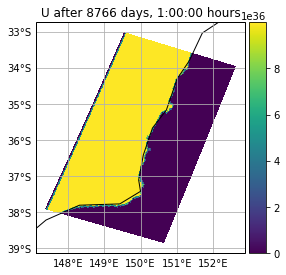

In [2]:
fieldset.U.show()

In [3]:
pset = ParticleSet.from_list(fieldset=fieldset,   # the fields on which the particles are advected
                             pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle)
                             lon=[150.5,  151], # a vector of release longitudes 
                             lat=[-37, -36])

In [4]:
print(pset)

P[0](lon=150.500000, lat=-37.000000, depth=0.000000, time=not_yet_set)
P[1](lon=151.000000, lat=-36.000000, depth=0.000000, time=not_yet_set)


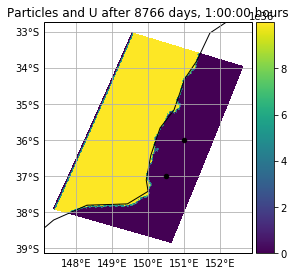

In [5]:
pset.show(field=fieldset.U)